# Multilayer Perceptron Regression

## 3.1 - Data preprocessing

In [11]:
import numpy as np
import pandas as pd

# import data
housing_data = pd.read_csv('HousingData.csv')
columns = housing_data.columns

housing_data = np.array(housing_data)

In [12]:
# replace NA values with mean of column
for i in range(housing_data.shape[1]):
    housing_data[np.isnan(housing_data[:,i]),i] = np.nanmean(housing_data[:,i])

In [13]:
# mean, standard deviation, min, and max values 

means = np.mean(housing_data, axis=0) # axis = 0 means column wise
stds = np.std(housing_data, axis=0)
mins = np.min(housing_data, axis=0)
maxs = np.max(housing_data, axis=0)

table = pd.DataFrame({"Features": columns ,"Mean": means, "Standard Deviation": stds, "Minimum": mins, "Maximum": maxs})
display(table)

,Features,Mean,Standard Deviation,Minimum,Maximum
0,CRIM,3.611874,8.537322,0.00632,88.9762
1,ZN,11.211934,22.898391,0.00000,100.0000
2,INDUS,11.083992,6.692542,0.46000,27.7400
3,CHAS,0.069959,0.249986,0.00000,1.0000
4,NOX,0.554695,0.115763,0.38500,0.8710
5,RM,6.284634,0.701923,3.56100,8.7800
6,AGE,68.518519,27.412339,2.90000,100.0000
7,DIS,3.795043,2.103628,1.12960,12.1265
8,RAD,9.549407,8.698651,1.00000,24.0000
9,TAX,408.237154,168.370495,187.00000,711.0000


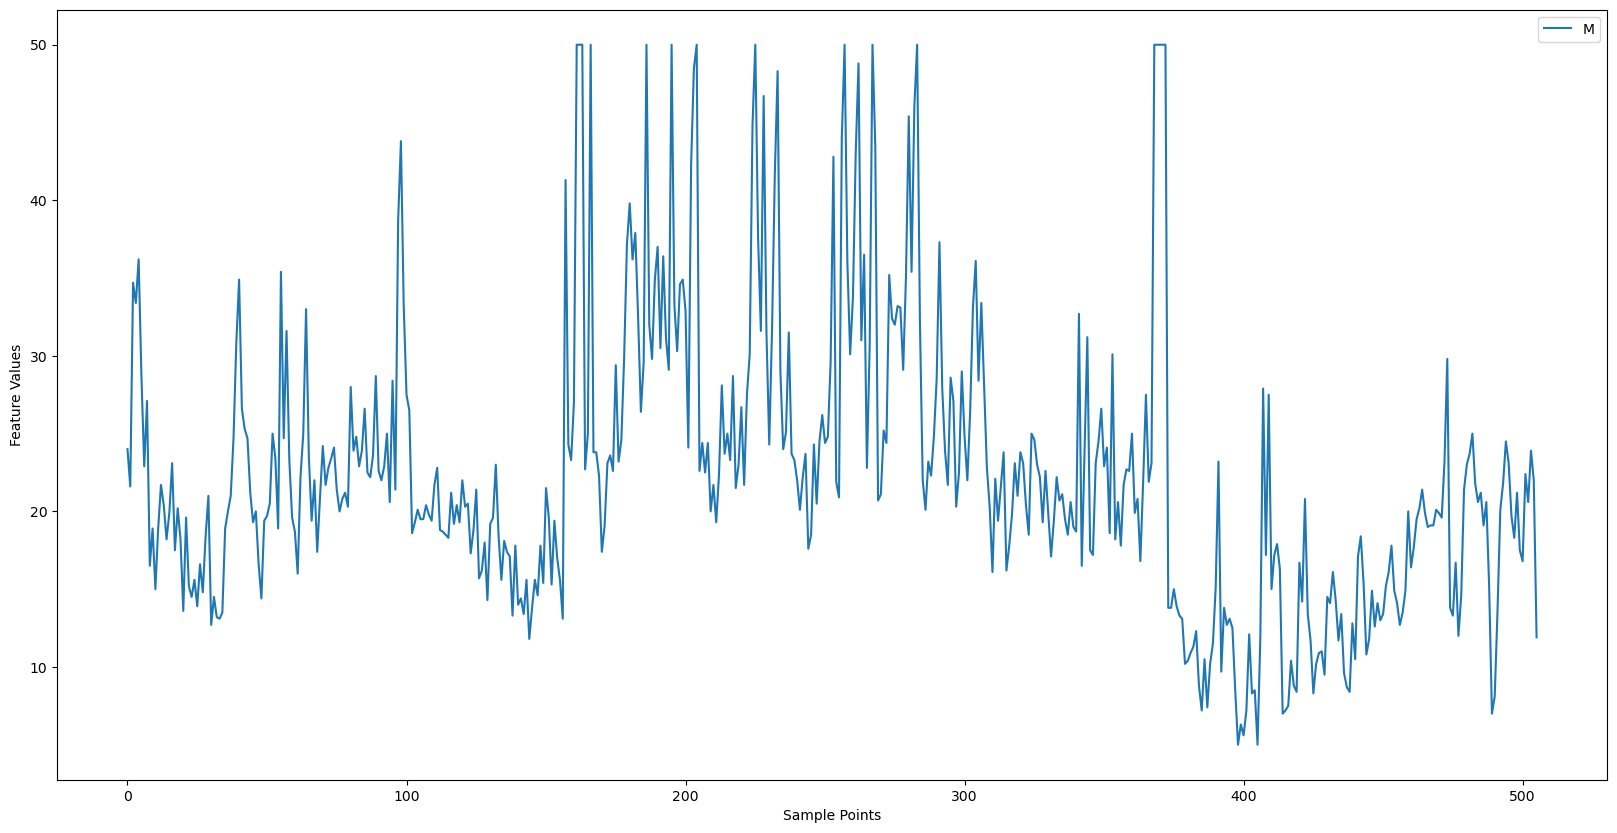

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(housing_data[:,-1])
plt.xlabel("Sample Points")
plt.ylabel("Feature Values")
plt.legend(columns[-1])
plt.show()


In [15]:
from sklearn.model_selection import train_test_split

# train test split
X = housing_data[:,:-1]
Y = housing_data[:,-1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# validation set split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

In [16]:
from sklearn.preprocessing import StandardScaler

# standardize data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 3.2 - MLP Regression Implementation from Scratch

In [19]:

import numpy as np

class MLPRegressor:
    def __init__(self, layer_sizes, learning_rate=0.01, n_epochs=1000, activation_function='sigmoid'):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.activation_function = activation_function

        # Initialize weights and biases in the same matrix for each layer
        self.weights_biases = []
        for i in range(self.num_layers - 1):
            weight_bias = np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1])
            self.weights_biases.append(weight_bias)

    def activation(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'relu':
            return np.maximum(0, x)
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        
    def activation_derivative(self, x):
        if self.activation_function == 'sigmoid':
            return x * (1 - x)
        elif self.activation_function == 'relu':
            return 1. * (x > 0)
        elif self.activation_function == 'tanh':
            return 1 - (np.tanh(x))**2
    def forward_propagation(self, X):
        activations = [X]
        output = X

        # Forward pass through the network except for the last layer
        for i in range(self.num_layers - 2):
            output = np.dot(self.add_bias(output), self.weights_biases[i])
            output = self.activation(output)
            activations.append(output)

        # Last layer without activation function (for regression)
        output = np.dot(self.add_bias(output), self.weights_biases[-1])
        activations.append(output)

        return activations, output

    def backward_propagation(self, X, y, activations):
        y=y.reshape(-1,1)
        error = activations[-1] - y

        # Backpropagation
        for i in range(self.num_layers - 2, -1, -1):
            gradient = np.dot(self.add_bias(activations[i]).T, error)
            error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])
            self.weights_biases[i] -= self.learning_rate * gradient


    def add_bias(self, X):
        return np.insert(X, len(X[0]), 1, axis=1)

    def fit(self, X, y, method='bgd'):
        if method == 'bgd':
            self.train_bgd(X, y)
        elif method == 'sgd':
            self.train_sgd(X, y)
        elif method == 'mbgd':
            self.train_mbgd(X, y)

    def train_bgd(self, X, y):
        self.learning_rate = self.learning_rate / len(X)
        for epoch in range(self.n_epochs):
            activations, predictions = self.forward_propagation(X)
            self.backward_propagation(X, y, activations)

    def train_sgd(self, X, y):
        for epoch in range(self.n_epochs):
            for i in range(len(X)):
                sample = X[i:i + 1]
                target = y[i:i + 1]
                activations, predictions = self.forward_propagation(sample)
                self.backward_propagation(sample, target, activations)

    def train_mbgd(self, X, y, batch_size=32):
        for epoch in range(self.n_epochs):
            for i in range(0, len(X), batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                activations, predictions = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch, activations)

    def predict(self, X):
        activations, predictions = self.forward_propagation(X)
        return predictions

In [8]:
# train model
model = MLPRegressor([13, 10, 1], learning_rate=0.01, n_epochs=1000, activation_function='relu')
model.fit(X_train_scaled, Y_train, method='bgd')
# print("Training Loss: ", mini)

# predict
Y_pred = model.predict(X_val_scaled)

print("Validation Loss: ", np.mean(np.square(Y_val - Y_pred)))

# check if any nan values in data



Validation Loss:  125.08414586987118


### Hyperparameters tuning

In [9]:
%pip install wandb -qU

Note: you may need to restart the kernel to use updated packages.


In [10]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: guptayatharth1. Use `wandb login --relogin` to force relogin


True

In [11]:
wandb.init(
    project="MLP-Regression",
)

In [12]:
# Initialize Weights & Biases Sweep
sweep_config = {
    'method': 'grid',  # You can choose different sweep methods (grid, random, etc.)
    'name': 'MLP-Regression_sweep',
    'metric': {'goal': 'minimize', 'name': 'MSE'},
    'parameters': {
        'lr': {'values': [ 0.005, 0.001, 0.01]},  # Learning rate values to experiment with
        'num_epochs': {'values': [200, 500, 1000]},  # Number of epochs to experiment with
        'hidden_layers': {'values': [[10], [2, 5], [10, 20], [2, 5, 10], [10, 20, 40]]},  # Hidden layer architecture to experiment with
        'activation': {'values': ['sigmoid', 'relu', 'tanh']},  # Activation function to experiment with
        'optimizer': {'values': ['sgd', 'bgd', 'mbgd']},  # Optimizer to experiment with
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="MLP-Regression")

Create sweep with ID: 9kv2xqse
Sweep URL: https://wandb.ai/guptayatharth1/MLP-Regression/sweeps/9kv2xqse


In [13]:
# hyperparameter tuning
# learning rate
# hidden layers
# number of neurons in each layer
# activation functions
# epochs


def train():
    # Initialize Weights & Biases run
    with wandb.init() as run:
        # Configure the logistic regression model with hyperparameters
        config = run.config
        model = MLPRegressor([13] + config.hidden_layers + [1], learning_rate=config.lr, n_epochs=config.num_epochs, activation_function=config.activation)
        
        # Train the model
        model.fit(X_train_scaled, Y_train, method=config.optimizer)

        # Evaluate the model
        Y_pred = model.predict(X_val_scaled)
        mse = np.mean(np.square(Y_val - Y_pred))

        # Log the hyperparameters and accuracy to the current run
        wandb.log({"MSE": mse})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()


# all_lr = [0.001, 0.01, 0.1]
# all_neurons = [[6], [10,9,5], [10,6,8,9]]
# all_act_func = ['sigmoid', 'relu', 'tanh']
# all_epochs = [500,1000, 2000]
# optimizer = ['bgd', 'sgd', 'mbgd']

# best_loss = 100000
# best_lr = None
# best_hidden_layers = None
# best_neurons = None
# best_act_func = None
# best_epochs = None
# best_optimizer = None

# for lr in all_lr:
#     for neurons in all_neurons:
#         for act_func in all_act_func:
#             for epochs in all_epochs:
#                 for opt in optimizer:
#                     model = MLPRegressor([13] + neurons + [1], learning_rate=lr, n_epochs=epochs, activation=act_func)
#                     model.fit(X_train_scaled, Y_train, method=opt)
#                     Y_pred = model.predict(X_val_scaled)
#                     loss = np.mean(np.square(Y_val - Y_pred))
#                     if loss < best_loss:
#                         best_loss = loss
#                         best_lr = lr
#                         best_hidden_layers = len(neurons)
#                         best_neurons = neurons
#                         best_act_func = act_func
#                         best_epochs = epochs
#                         best_optimizer = opt
#     print("Learning Rate: ", lr, "Loss: ", best_loss)

# print("Best Loss: ", best_loss)
# print("Best Learning Rate: ", best_lr)
# print("Best Hidden Layers: ", best_hidden_layers)
# print("Best Neurons: ", best_neurons)
# print("Best Activation Function: ", best_act_func)
# print("Best Epochs: ", best_epochs)
# print("Best Optimizer: ", best_optimizer)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: dy1s79ft with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


Exception in thread Exception in thread IntMsgThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
        Exception in thread self._target(*self._args, **self._kwargs)self._target(*self._args, **self._kwargs)NetStatThr

:
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 300, in check_internal_messages
  File "/home/yatharth-gupta/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 286, in check_stop_status
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self._loop_check_status(
  File "/home/yatharth-gupta/.local/lib/python3.10/site-pac

MSE,▁
MSE,122.07046


wandb: Agent Starting Run: wiv6o32f with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,109.54389


wandb: Agent Starting Run: 85cmfxmj with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,108.6085


wandb: Agent Starting Run: ymmc99gz with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,131.2888


wandb: Agent Starting Run: 22yz1dw4 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,107.2301


wandb: Agent Starting Run: suc391lg with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,118.56881


wandb: Agent Starting Run: 5v7es93n with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,118.57224


wandb: Agent Starting Run: phou2h7r with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,114.97509


wandb: Agent Starting Run: dngg8dbb with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,122.83976


wandb: Agent Starting Run: sehem552 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,121.2794


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3h4umkyc with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,159.36494


wandb: Agent Starting Run: 6kxl0p3w with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,110.82815


wandb: Agent Starting Run: rbwqout6 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,114.93878


wandb: Agent Starting Run: 720dtwlp with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,90.83698


wandb: Agent Starting Run: x1o0iqua with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,119.41597


wandb: Agent Starting Run: 72oemrj2 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,115.18715


wandb: Agent Starting Run: 331kjr4c with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,100.21621


wandb: Agent Starting Run: 9cyrtqo5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,115.39975


wandb: Agent Starting Run: k96pjfkk with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,111.55827


wandb: Agent Starting Run: 99ajqune with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,113.07088


wandb: Agent Starting Run: vc7xgybt with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,125.07072


wandb: Agent Starting Run: 4uqlec9q with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,119.33242


wandb: Agent Starting Run: ziayjg40 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,111.09707


wandb: Agent Starting Run: fccbtkv0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,120.81991


wandb: Agent Starting Run: 92sis3th with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,110.28371


wandb: Agent Starting Run: slykfdfm with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,121.88137


wandb: Agent Starting Run: thni2fom with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,118.33252


wandb: Agent Starting Run: aufzf8hq with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,119.58537


wandb: Agent Starting Run: bg3zpn6c with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,68.75053


wandb: Agent Starting Run: isahooe8 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,129.95236


wandb: Agent Starting Run: ued36kcv with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,108.65804


wandb: Agent Starting Run: v8usakwm with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,95.18418


wandb: Agent Starting Run: gwa2yndw with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,121.40565


wandb: Agent Starting Run: 0hc6fp4l with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,117.24301


wandb: Agent Starting Run: boaz5m2f with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,109.18365


wandb: Agent Starting Run: dwy0u0nr with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,122.31953


wandb: Agent Starting Run: otxjpfgr with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,112.56633


wandb: Agent Starting Run: jcizveao with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,177.35531


wandb: Agent Starting Run: wigs7vd4 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,108.24735


wandb: Agent Starting Run: zm777jfr with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,120.94653


wandb: Agent Starting Run: tv7ug4j6 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,72.40919


wandb: Agent Starting Run: nk1nyspq with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,132.93599


wandb: Agent Starting Run: d5ntvxk3 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,130.70241


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qsk6jbmk with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,71.14439


wandb: Agent Starting Run: pkuhtve8 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,116.18319


wandb: Agent Starting Run: xh1dcnnn with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,113.77615


wandb: Agent Starting Run: zgrwc8jf with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,93.91748


wandb: Agent Starting Run: rc0j4hjy with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,101.16056


wandb: Agent Starting Run: otyg2558 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,117.23175


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mq8vu64f with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,102.20233


wandb: Agent Starting Run: 605nb4zu with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,121.41837


wandb: Agent Starting Run: w57smhkd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,131.79527


wandb: Agent Starting Run: kccxsdbt with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,107.337


wandb: Agent Starting Run: caaxtl6s with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,155.87823


wandb: Agent Starting Run: csrb0gfa with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,126.26932


wandb: Agent Starting Run: f6ifmoij with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,91.81647


wandb: Agent Starting Run: ohi9ay2g with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,114.10152


wandb: Agent Starting Run: 29c5tr5w with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,121.14285


wandb: Agent Starting Run: 56jko7ac with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,106.54815


wandb: Agent Starting Run: 7fyjie4h with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,124.3833


wandb: Agent Starting Run: dyc127yf with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,112.56671


wandb: Agent Starting Run: wxygtnj0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,109.86966


wandb: Agent Starting Run: o5ic0pei with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,124.86226


wandb: Agent Starting Run: i43p14eq with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,110.75854


wandb: Agent Starting Run: uskfc23n with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,67.96911


wandb: Agent Starting Run: 3dd8l7up with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,124.27395


wandb: Agent Starting Run: 4a5edz7h with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,122.57917


wandb: Agent Starting Run: jfsma95t with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,83.60898


wandb: Agent Starting Run: 885nhxgx with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,119.15164


wandb: Agent Starting Run: i4itgt7t with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,121.73323


wandb: Agent Starting Run: rbt2hcm0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,87.09278


wandb: Agent Starting Run: 9izxob7n with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,133.25016


wandb: Agent Starting Run: z6elmrlu with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,122.23202


wandb: Agent Starting Run: 19qjpu4c with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,95.64709


wandb: Agent Starting Run: hkv4xhnw with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,128.20101


wandb: Agent Starting Run: p2u7fzkd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,130.3696


wandb: Agent Starting Run: w4k8k4c0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,114.26624


wandb: Agent Starting Run: bmageii5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,111.54431


wandb: Agent Starting Run: qvtqq80x with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,129.73988


wandb: Agent Starting Run: 3x5vi8k1 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,121.43373


wandb: Agent Starting Run: b88nb8to with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,140.64672


wandb: Agent Starting Run: ongi6kuz with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,107.49397


wandb: Agent Starting Run: w48jw8ux with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,67.3344


wandb: Agent Starting Run: ngfe26o7 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,116.1328


wandb: Agent Starting Run: vwqz4iaa with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,114.19928


wandb: Agent Starting Run: xxvfsx48 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,93.91553


wandb: Agent Starting Run: xv7zen7i with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,126.72729


wandb: Agent Starting Run: f2lrtxfq with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,114.82158


wandb: Agent Starting Run: x8naw4mt with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,94.22324


wandb: Agent Starting Run: trns5wat with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,111.03959


wandb: Agent Starting Run: gc54wigu with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,118.48107


wandb: Agent Starting Run: 7cim6ph4 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,72.92413


wandb: Agent Starting Run: 8sgxa449 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,127.92054


wandb: Agent Starting Run: m9d3ah44 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,114.37026


wandb: Agent Starting Run: qya3s1es with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,66.61348


wandb: Agent Starting Run: 0z6i72tm with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,133.39105


wandb: Agent Starting Run: 1vt1kqm3 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,119.55668


wandb: Agent Starting Run: 7ih6ukcs with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,67.43079


wandb: Agent Starting Run: r07pg8pm with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,121.37013


wandb: Agent Starting Run: yfhfe64z with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,126.17071


wandb: Agent Starting Run: z9w0m7ly with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,67.5673


wandb: Agent Starting Run: 9se2u5ok with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,106.64948


wandb: Agent Starting Run: 4dx9zr87 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,120.35517


wandb: Agent Starting Run: 9bfz1h8j with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,107.28729


wandb: Agent Starting Run: wy814f93 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,110.7467


wandb: Agent Starting Run: ir475o51 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,118.41047


wandb: Agent Starting Run: seks0px5 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,98.34768


wandb: Agent Starting Run: kp5yj0dr with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,116.23271


wandb: Agent Starting Run: 0rqo3yac with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,127.54256


wandb: Agent Starting Run: oamxn6ut with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,83.89398


wandb: Agent Starting Run: q3wwojf1 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,130.46632


wandb: Agent Starting Run: acizwoyp with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,122.6337


wandb: Agent Starting Run: 5lb8q29r with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,102.05836


wandb: Agent Starting Run: k3kh3lv8 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,116.74683


wandb: Agent Starting Run: 2x7j5fb8 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,134.53395


wandb: Agent Starting Run: o6colf1l with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,115.28327


wandb: Agent Starting Run: 62bzlh3s with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,133.67183


wandb: Agent Starting Run: fc1nrr87 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,114.27353


wandb: Agent Starting Run: cqnypc7q with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,67.08709


wandb: Agent Starting Run: y7jrnhft with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,122.7356


wandb: Agent Starting Run: h5f2vjk8 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,115.91335


wandb: Agent Starting Run: 6n19zynd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,81.58499


wandb: Agent Starting Run: gsgs8tsg with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,120.83454


wandb: Agent Starting Run: ro89utmv with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,119.02482


wandb: Agent Starting Run: xwryuwfd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,82.79309


wandb: Agent Starting Run: vkmkbczw with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,132.536


wandb: Agent Starting Run: 1dfwcj5h with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,128.74133


wandb: Agent Starting Run: dh1d5ib0 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,105.67772


wandb: Agent Starting Run: u77cpqj7 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:19: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


MSE,▁
MSE,65.77006


wandb: Agent Starting Run: pr25h3s4 with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,126.27557


wandb: Agent Starting Run: 5nqc9gsu with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,119.18724


wandb: Agent Starting Run: v4sngeyg with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:19: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


MSE,▁
MSE,66.05276


wandb: Agent Starting Run: 3byh5z5d with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,130.18882


wandb: Agent Starting Run: sg9e06gd with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,125.54435


wandb: Agent Starting Run: 10x788cv with config:
wandb: 	activation: sigmoid
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:19: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


MSE,▁
MSE,65.77006


wandb: Agent Starting Run: 7856rd4u with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,120.12241


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xe9g7syh with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,133.88502


wandb: Agent Starting Run: shtjq6mp with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: yxqsv3lb with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,123.46912


wandb: Agent Starting Run: vkdz0f1w with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,128.28438


wandb: Agent Starting Run: faqlhbxv with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: vh3pfu65 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,151.68037


wandb: Agent Starting Run: brwchkgq with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,123.45326


wandb: Agent Starting Run: m90dp7up with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 9zobolfh with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,125.6865


wandb: Agent Starting Run: awaaaa7y with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,135.85378


wandb: Agent Starting Run: iu60em3w with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,131.20284


wandb: Agent Starting Run: iw8ga4ko with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,123.00424


wandb: Agent Starting Run: dmhr51em with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,127.86006


wandb: Agent Starting Run: urqdokzu with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,123.70565


wandb: Agent Starting Run: hzu218om with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,132.72727


wandb: Agent Starting Run: 56b3760e with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,120.21929


wandb: Agent Starting Run: hd6c2wiv with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,121.16362


wandb: Agent Starting Run: cb29kjum with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pgmhsb33 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,126.73167


wandb: Agent Starting Run: ql19e44w with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: p3ua5ujz with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5umx5h30 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,126.06808


wandb: Agent Starting Run: pl3q6u2x with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 271irp1p with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l7yna543 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,132.1872


wandb: Agent Starting Run: ueu52gxn with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: hjvhpr5g with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,71.82204


wandb: Agent Starting Run: 2ph4iy4o with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,140.00602


wandb: Agent Starting Run: 13p1s7er with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: q7zph5mb with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,96.83003


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dif69iwd with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,120.15121


wandb: Agent Starting Run: 2bzad6g4 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: 72dho9n3 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,93.82581


wandb: Agent Starting Run: 2e23hnm7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,127.22037


wandb: Agent Starting Run: fitmd5md with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: c3oaiaqs with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,111.35063


wandb: Agent Starting Run: 8i9pfv5g with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,120.88805


wandb: Agent Starting Run: 9nc9kqms with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,132.33436


wandb: Agent Starting Run: pxd3pove with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,117.38118


wandb: Agent Starting Run: l137ctvo with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,125.82022


wandb: Agent Starting Run: dd6ymqwp with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,67.30361


wandb: Agent Starting Run: 9rnkay25 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,119.81916


wandb: Agent Starting Run: vqewz5h3 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,127.97612


wandb: Agent Starting Run: 3yf44aem with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,135.97283


wandb: Agent Starting Run: ugarfon4 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,66.48535


wandb: Agent Starting Run: 0nywyy3u with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,111.19719


wandb: Agent Starting Run: kwn7c8ag with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: jn0bz2u9 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,78.85097


wandb: Agent Starting Run: lwi7e0mb with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,121.92146


wandb: Agent Starting Run: ly8wm6xg with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: k7ev81d4 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,66.48535


wandb: Agent Starting Run: zw99lwck with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,127.74613


wandb: Agent Starting Run: iayts3ql with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: 3edqnjl2 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vki9h97t with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,123.26493


wandb: Agent Starting Run: sbgbertw with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: 7brfom3r with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 7a9dbpnm with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,118.54175


wandb: Agent Starting Run: jvclizyo with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: 5ati5u15 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: mn1fkfm3 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,125.4474


wandb: Agent Starting Run: 1e06t8yn with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: j9bz9iil with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,127.11813


wandb: Agent Starting Run: 16c566z7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,130.24527


wandb: Agent Starting Run: hcndevfg with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,67.30361


wandb: Agent Starting Run: sofs4thd with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,128.82545


wandb: Agent Starting Run: rt5i1vf3 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,138.80667


wandb: Agent Starting Run: 9z2x07f4 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,67.30361


wandb: Agent Starting Run: noju9yjf with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,130.30432


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: quu5lgtc with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,129.40607


wandb: Agent Starting Run: pmcswgid with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,67.30361


wandb: Agent Starting Run: tsdgchxn with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5fzk7uce with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 54da16zy with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: ug0slulk with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,66.48535


wandb: Agent Starting Run: 6s407rm8 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,117.66645


wandb: Agent Starting Run: yccb5sow with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: wxfcvq4e with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: l3d5eiff with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,67.44041


wandb: Agent Starting Run: m31g3hwx with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: kqeepyyn with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,126.29098


wandb: Agent Starting Run: wjsggsod with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,114.51217


wandb: Agent Starting Run: phwq1qa7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: 7gk7vwfz with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,66.88166


wandb: Agent Starting Run: 7ri4546q with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,128.32998


wandb: Agent Starting Run: ityvccyn with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: wj5sya0m with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,66.88166


wandb: Agent Starting Run: 2hrbe39t with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,111.74997


wandb: Agent Starting Run: 94imvabm with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: v21m9228 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,110.20664


wandb: Agent Starting Run: b67p1kg2 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,128.62547


wandb: Agent Starting Run: omep7hjz with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.04045


wandb: Agent Starting Run: ijlfydqf with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,102.40391


wandb: Agent Starting Run: sw2h8sw1 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,127.11809


wandb: Agent Starting Run: nlzbvi1z with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,67.30361


wandb: Agent Starting Run: j2mneu26 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,109.08315


wandb: Agent Starting Run: 3bad9k1f with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,106.13225


wandb: Agent Starting Run: 0qsiaot4 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,67.30361


wandb: Agent Starting Run: depgrs6n with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,66.48535


wandb: Agent Starting Run: rx5x817z with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,130.95925


wandb: Agent Starting Run: lum06c5y with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: j8o2mbqf with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,66.48535


wandb: Agent Starting Run: icumgje4 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,93.84775


wandb: Agent Starting Run: bahrdunm with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: 10hzl6py with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,66.48535


wandb: Agent Starting Run: xohtgdrt with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,136.56642


wandb: Agent Starting Run: bltef6yj with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: 2t8yfkeh with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: vz250uc8 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: qfslksw2 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 59aw3z14 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 0oy66evk with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 3320ruaw with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: icljy9k7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pgz3omrv with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,9.946864924093508e+236


wandb: Agent Starting Run: r1izax7h with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.82349


wandb: Agent Starting Run: 5cv08lyb with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: wi9te4k9 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: nbwi5osl with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,8313305288516.298


wandb: Agent Starting Run: kv6nu2us with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: m5ydozxi with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,3071665397.88007


wandb: Agent Starting Run: 81m5ww2j with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,67.30361


wandb: Agent Starting Run: enmvzeo7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ylhcjeuw with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: z578ujbx with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: usspkds7 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: g0u16pgq with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,3.4308900613498105e+55


wandb: Agent Starting Run: 6bux1qmf with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: ho582wff with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,nan


wandb: Agent Starting Run: wn1p24ls with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,4.479355187837211e+217


wandb: Agent Starting Run: 791jssp6 with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,66.39463


wandb: Agent Starting Run: cn1d46ng with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: 43e3q6cd with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6gr32nu with config:
wandb: 	activation: relu
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:55: RuntimeWarning: invalid value encountered in multiply
  error = np.dot(error, self.weights_biases[i][:-1].T) * self.activation_derivative(activations[i])


MSE,nan


wandb: Agent Starting Run: e0jua24c with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,95.83841


wandb: Agent Starting Run: p7je4eky with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,138.36667


wandb: Agent Starting Run: 0q0nrgxi with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,78.28517


wandb: Agent Starting Run: psjpm324 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,97.63357


wandb: Agent Starting Run: jskbdvia with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,134.45069


wandb: Agent Starting Run: c26uy6z5 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,78.93832


wandb: Agent Starting Run: vlbrmgpc with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,97.69956


wandb: Agent Starting Run: 6d8fyku1 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,143.90596


wandb: Agent Starting Run: mlj25zxh with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,83.62078


wandb: Agent Starting Run: m8h3tvnk with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,102.87678


wandb: Agent Starting Run: yvdyqibf with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,209.87657


wandb: Agent Starting Run: 82p9lmwt with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,101.18022


wandb: Agent Starting Run: 9tylkm3q with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,102.18809


wandb: Agent Starting Run: s645gdtu with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,110.7479


wandb: Agent Starting Run: t6m5kdn2 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,102.24923


wandb: Agent Starting Run: 6fzxpqti with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,104.45568


wandb: Agent Starting Run: t84dtkt6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,131.42885


wandb: Agent Starting Run: cvst36nh with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,102.21503


wandb: Agent Starting Run: wi81clk8 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,95.46721


wandb: Agent Starting Run: xl8vom98 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,130.64133


wandb: Agent Starting Run: tasb0x0g with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,116.54253


wandb: Agent Starting Run: xaqq4uoi with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,98.87851


wandb: Agent Starting Run: neibbz1m with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,139.90278


wandb: Agent Starting Run: 7j7lf1pw with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,106.23148


wandb: Agent Starting Run: vts4ldq5 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,100.59885


wandb: Agent Starting Run: ykqt5kp5 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,117.75735


wandb: Agent Starting Run: lram9hap with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,102.5675


wandb: Agent Starting Run: 1muci3ph with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,98.03304


wandb: Agent Starting Run: ki2mk1jj with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,94.37296


wandb: Agent Starting Run: oumey14x with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,96.67679


wandb: Agent Starting Run: r0yjyjpg with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,98.86922


wandb: Agent Starting Run: pj4sbr2n with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,99.69985


wandb: Agent Starting Run: 4j05012z with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,98.22533


wandb: Agent Starting Run: prv4zob8 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,100.13184


wandb: Agent Starting Run: pc8ow256 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,101.25827


wandb: Agent Starting Run: c2ilq41s with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,98.53384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zl84xswx with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,102.66386


wandb: Agent Starting Run: 90d3mk1m with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,137.9549


wandb: Agent Starting Run: zvviphta with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,100.46649


wandb: Agent Starting Run: 0v2e7m3e with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,101.64929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0fvo128w with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,120.41776


wandb: Agent Starting Run: sh7zq1ow with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,100.68894


wandb: Agent Starting Run: cmpefx8k with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,101.93073


wandb: Agent Starting Run: ap0jxstx with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,96.38111


wandb: Agent Starting Run: vv6b28qg with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,101.56623


wandb: Agent Starting Run: qs8odb95 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,97.34865


wandb: Agent Starting Run: 69go9h7i with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,100.90842


wandb: Agent Starting Run: cl2d91fk with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,92.10566


wandb: Agent Starting Run: bunx1h2u with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,99.69993


wandb: Agent Starting Run: v1f3sl3e with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,101.50521


wandb: Agent Starting Run: l2v02kcv with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,96.66353


wandb: Agent Starting Run: lotqlg67 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,98.94672


wandb: Agent Starting Run: ykhmjcap with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,101.88387


wandb: Agent Starting Run: 6atrlwgz with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,96.11978


wandb: Agent Starting Run: 0cyqzg4j with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,105.19451


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u8u0q4eh with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,120.46551


wandb: Agent Starting Run: 4bq21jjy with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


/tmp/ipykernel_44420/555461009.py:56: RuntimeWarning: invalid value encountered in subtract
  self.weights_biases[i] -= self.learning_rate * gradient


MSE,nan


wandb: Agent Starting Run: x9e7p07b with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,98.70466


wandb: Agent Starting Run: ozf57wqw with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,109.77052


wandb: Agent Starting Run: j81kuyer with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,99.91772


wandb: Agent Starting Run: c77tksbc with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,99.33809


wandb: Agent Starting Run: 4x9gfzfp with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,110.07702


wandb: Agent Starting Run: mnwaug84 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,97.6332


wandb: Agent Starting Run: qrgve1qk with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,111.81827


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: upeftv8s with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,117.05291


wandb: Agent Starting Run: shyek5ex with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,107.84503


wandb: Agent Starting Run: oqef1ubb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,116.19207


wandb: Agent Starting Run: audu347v with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,122.08208


wandb: Agent Starting Run: m91rmbd6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,113.22078


wandb: Agent Starting Run: 71qrxl9d with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,105.96678


wandb: Agent Starting Run: b9wjd3z7 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,131.65634


wandb: Agent Starting Run: am7my4cc with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,110.75046


wandb: Agent Starting Run: 7iaux004 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,98.72471


wandb: Agent Starting Run: 3qppt1f4 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,115.93289


wandb: Agent Starting Run: 7pibh6j3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: q0gj002k with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,100.91068


wandb: Agent Starting Run: 6rvan73d with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,120.22639


wandb: Agent Starting Run: 9199u3gy with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: xjs3oi1h with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,98.93566


wandb: Agent Starting Run: d4st2zl0 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,112.66846


wandb: Agent Starting Run: 500rzzvt with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c4gcjv77 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,99.35933


wandb: Agent Starting Run: jqj4hiho with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,92.78897


wandb: Agent Starting Run: uaykisq2 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,98.09671


wandb: Agent Starting Run: hkg5x029 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,96.03621


wandb: Agent Starting Run: a9a7r79c with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,98.3313


wandb: Agent Starting Run: s78wu1hz with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,99.18982


wandb: Agent Starting Run: lr1g2519 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,104.13399


wandb: Agent Starting Run: 21y29oef with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,102.79276


wandb: Agent Starting Run: 3b9nou5f with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,97.80588


wandb: Agent Starting Run: 2qc810lz with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,101.56922


wandb: Agent Starting Run: 5wtwsfp6 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,82.10713


wandb: Agent Starting Run: 7gkom9rz with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,100.96528


wandb: Agent Starting Run: 2kwkbq2a with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,100.43011


wandb: Agent Starting Run: wrtdlhjb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,103.24442


wandb: Agent Starting Run: dns0jfh3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,101.03908


wandb: Agent Starting Run: lmyjoxj3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,101.65295


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qrcsrbd0 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,99.2383


wandb: Agent Starting Run: k5o31e0e with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,100.16384


wandb: Agent Starting Run: ejk4bhln with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,98.98484


wandb: Agent Starting Run: sbeoc5pq with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,101.21938


wandb: Agent Starting Run: 0rkfah0q with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: dubldnux with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,100.08353


wandb: Agent Starting Run: hfwire4g with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,102.096


wandb: Agent Starting Run: 31y3mmt1 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: qcg4dc0e with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,96.74007


wandb: Agent Starting Run: s8paxeyj with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,100.88044


wandb: Agent Starting Run: cz44fxwl with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [2, 5, 10]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: ecaybpge with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,99.24061


wandb: Agent Starting Run: 7r6x02o2 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,115.36655


wandb: Agent Starting Run: huqai9lt with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: imqrgw7v with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,99.06368


wandb: Agent Starting Run: 0itjrc4w with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,138.53087


wandb: Agent Starting Run: 5pfj3p3l with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: g8a2g2qm with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,100.40538


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vg6j0n0d with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,109.63759


wandb: Agent Starting Run: ocv8xbxi with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.005
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: fzbyww2x with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,109.30455


wandb: Agent Starting Run: 7u4ka6lt with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,118.20828


wandb: Agent Starting Run: wbtuk02d with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,▁
MSE,115.27383


wandb: Agent Starting Run: ei7uh6hr with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,107.40541


wandb: Agent Starting Run: msbks2zb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,119.69322


wandb: Agent Starting Run: 4k8uvsib with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,▁
MSE,100.77176


wandb: Agent Starting Run: 1hd08fwp with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,117.329


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wiyc2cmi with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,103.51449


wandb: Agent Starting Run: mcrcnkye with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.001
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,▁
MSE,99.55264


wandb: Agent Starting Run: qcl844jc with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: sgd


MSE,▁
MSE,99.2906


wandb: Agent Starting Run: k8mq9cpb with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: bgd


MSE,▁
MSE,130.34628


wandb: Agent Starting Run: 9f1jkmod with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: 6hsri4c3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: sgd


MSE,▁
MSE,99.22086


wandb: Agent Starting Run: wkvc6rc3 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: bgd


MSE,▁
MSE,127.82526


wandb: Agent Starting Run: bsh8mms5 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 500
wandb: 	optimizer: mbgd


MSE,nan


wandb: Agent Starting Run: t0goyoe2 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: sgd


MSE,▁
MSE,98.27745


wandb: Agent Starting Run: 5hndqpe4 with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: bgd


MSE,▁
MSE,119.72908


wandb: Agent Starting Run: ww07tfjl with config:
wandb: 	activation: tanh
wandb: 	hidden_layers: [10, 20, 40]
wandb: 	lr: 0.01
wandb: 	num_epochs: 1000
wandb: 	optimizer: mbgd


MSE,nan


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fedc97392a0>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [27]:
import numpy as np
# test model on best hyperparameters
model = MLPRegressor([13,10,20,40,1], learning_rate=0.01, n_epochs=1000, activation_function='sigmoid')
model.fit(X_train_scaled, Y_train, method='mbgd')
Y_pred = model.predict(X_test_scaled)
print("Test Loss: ", np.mean(np.square(Y_test - Y_pred)))

# rmse
print("RMSE: ", np.sqrt(np.mean(np.square(Y_test - Y_pred))))

# r-squared
from sklearn.metrics import r2_score
print("R-Squared: ", r2_score(Y_test, Y_pred))

/tmp/ipykernel_4721/555461009.py:19: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Test Loss:  138.74211860642342
RMSE:  11.778884438113119
R-Squared:  0.4286643916773595
